This example is a breakdown of the train code released with pytorch-CycleGAN-and-pix2pix.  It's less generic - I'm only including the ResNet implementation, and using their default options from the actual code.

### Generator Network

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import numpy as np
import random
import itertools

In [3]:
ngpus = 1
batch_size = 1

In [4]:
# Define a resnet block, using reflective padding and InstanceNorm
class ResnetBlock(nn.Module):
    def __init__(self, dim, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, use_bias)
    def build_conv_block(self, dim, use_bias):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [5]:
# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64):
        super(ResnetGenerator, self).__init__()
        use_bias = True
        n_downsampling = 2
        n_blocks = 9

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        if ngpus > 1:
            return nn.parallel.data_parallel(self.model, input, range(ngpus))
        return self.model(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0)

In [7]:
# create generator network
def define_G(input_nc, output_nc, ngf):
    netG = ResnetGenerator(input_nc, output_nc, ngf)
    netG.apply(weights_init)
    return netG

### Discriminator Network

In [8]:
# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        use_bias = True
        kw = 4
        padw = int(np.ceil((kw-1)/2))
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if ngpus > 1:
            return nn.parallel.data_parallel(self.model, input, range(ngpus))
        return self.model(input)

In [9]:
def define_D(input_nc, ndf, n_layers_D=3):
    netD = NLayerDiscriminator(input_nc, ndf, n_layers=3)
    netD.apply(weights_init)
    return netD

### Loss Function

In [10]:
# Defines the GAN loss which uses either LSGAN or the regular GAN.
# When LSGAN is used, it is basically same as MSELoss,
# but it abstracts away the need to create the target label tensor
# that has the same size as the input
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = torch.FloatTensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = torch.FloatTensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        if torch.cuda.is_available():
            target_tensor = target_tensor.cuda()
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

### Image Pool

In [11]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

### CycleGAN

In [12]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

In [13]:
class CycleGANModel(object):
    def initialize(self, isTrain = True):
        self.nb = 1 # batch size
        self.size = 256 # crop size
        self.input_nc = 3 # number of input channels
        self.output_nc = 3 # number of output channels
        self.ngf = 64 # number of generative filters in the first conv layer
        self.ndf = 64 # number of discriminative filters in the first conv layer
        self.pool_size = 50 # size of image buffer that stores previously generated images
        self.lr = 0.0002 # initial learning rate for Adam
        self.old_lr = 0.0002 # initial learning rate for Adam
        self.beta1 = 0.5 # momentum term for Adam
        self.identity = 0.0 # use identity mapping. Setting identity other than 1 has an effect of scaling the weight of the identity mapping loss. For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set optidentity = 0.1
        self.lambda_A = 10.0 # weight for cycle loss (A -> B -> A)
        self.lambda_B = 10.0 # weight for cycle loss (B -> A -> B)
        self.checkpoint_dir = 'checkpoints'
        
        # inputs
        self.input_A = torch.FloatTensor(self.nb, self.input_nc, self.size, self.size)
        self.input_B = torch.FloatTensor(self.nb, self.output_nc, self.size, self.size)

        # generators
        self.netG_A = define_G(self.input_nc, self.output_nc, self.ngf)
        self.netG_B = define_G(self.output_nc, self.input_nc, self.ngf)
        if torch.cuda.is_available():
            self.netG_A.cuda()
            self.netG_B.cuda()

        if isTrain:
            # discriminators
            self.netD_A = define_D(self.output_nc, self.ndf)
            self.netD_B = define_D(self.input_nc, self.ndf)
            if torch.cuda.is_available():
                self.netD_A.cuda()
                self.netD_B.cuda()
            
            self.fake_A_pool = ImagePool(self.pool_size)
            self.fake_B_pool = ImagePool(self.pool_size)
            # define loss functions
            self.criterionGAN = GANLoss(use_lsgan=True)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()

            # initialize optimizers
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()),
                                                lr=self.old_lr, betas=(self.beta1, 0.999))
            self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=self.old_lr, betas=(self.beta1, 0.999))
            self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=self.old_lr, betas=(self.beta1, 0.999))
            self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=self.old_lr, betas=(self.beta1, 0.999))

        print('---------- Networks initialized -------------')
        print_network(self.netG_A)
        print_network(self.netG_B)
        if isTrain:
            print_network(self.netD_A)
            print_network(self.netD_B)
        print('-----------------------------------------------')

    def set_input(self, input):
        input_A = input['A']
        input_B = input['B']
        self.input_A.resize_(input_A.size()).copy_(input_A)
        self.input_B.resize_(input_B.size()).copy_(input_B)
        self.image_paths = input['A_paths']

    def forward(self):
        self.real_A = Variable(self.input_A)
        self.real_B = Variable(self.input_B)
        if torch.cuda.is_available():
            self.real_A = self.real_A.cuda()
            self.real_B = self.real_B.cuda()

    def test(self):
        self.real_A = Variable(self.input_A, volatile=True)
        self.real_B = Variable(self.input_B, volatile=True)
        if torch.cuda.is_available():
            self.real_A = self.real_A.cuda()
            self.real_B = self.real_B.cuda()

        self.fake_B = self.netG_A.forward(self.real_A)
        self.rec_A = self.netG_B.forward(self.fake_B)

        self.fake_A = self.netG_B.forward(self.real_B)
        self.rec_B = self.netG_A.forward(self.fake_A)

    # get image paths
    def get_image_paths(self):
        return self.image_paths

    def backward_D_basic(self, netD, real, fake):
        # Real
        pred_real = netD.forward(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD.forward(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        # backward
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        lambda_idt = self.identity
        lambda_A = self.lambda_A
        lambda_B = self.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed.
            self.idt_A = self.netG_A.forward(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed.
            self.idt_B = self.netG_B.forward(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss
        # D_A(G_A(A))
        self.fake_B = self.netG_A.forward(self.real_A)
        pred_fake = self.netD_A.forward(self.fake_B)
        self.loss_G_A = self.criterionGAN(pred_fake, True)
        # D_B(G_B(B))
        self.fake_A = self.netG_B.forward(self.real_B)
        pred_fake = self.netD_B.forward(self.fake_A)
        self.loss_G_B = self.criterionGAN(pred_fake, True)
        # Forward cycle loss
        self.rec_A = self.netG_B.forward(self.fake_B)
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss
        self.rec_B = self.netG_A.forward(self.fake_A)
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

    def optimize_parameters(self):
        # forward
        self.forward()
        # G_A and G_B
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        # D_A
        self.optimizer_D_A.zero_grad()
        self.backward_D_A()
        self.optimizer_D_A.step()
        # D_B
        self.optimizer_D_B.zero_grad()
        self.backward_D_B()
        self.optimizer_D_B.step()

    def get_current_errors(self):
        D_A = self.loss_D_A.data[0]
        G_A = self.loss_G_A.data[0]
        Cyc_A = self.loss_cycle_A.data[0]
        D_B = self.loss_D_B.data[0]
        G_B = self.loss_G_B.data[0]
        Cyc_B = self.loss_cycle_B.data[0]
        if self.identity > 0.0:
            idt_A = self.loss_idt_A.data[0]
            idt_B = self.loss_idt_B.data[0]
            return OrderedDict([('D_A', D_A), ('G_A', G_A), ('Cyc_A', Cyc_A), ('idt_A', idt_A),
                                ('D_B', D_B), ('G_B', G_B), ('Cyc_B', Cyc_B), ('idt_B', idt_B)])
        else:
            return OrderedDict([('D_A', D_A), ('G_A', G_A), ('Cyc_A', Cyc_A),
                                ('D_B', D_B), ('G_B', G_B), ('Cyc_B', Cyc_B)])

    def save(self, label):
        self.save_network(self.netG_A, 'G_A', label)
        self.save_network(self.netD_A, 'D_A', label)
        self.save_network(self.netG_B, 'G_B', label)
        self.save_network(self.netD_B, 'D_B', label)

    def update_learning_rate(self, niter_decay):
        lrd = self.lr / niter_decay
        lr = self.old_lr - lrd
        for param_group in self.optimizer_D_A.param_groups:
            param_group['lr'] = lr
        for param_group in self.optimizer_D_B.param_groups:
            param_group['lr'] = lr
        for param_group in self.optimizer_G.param_groups:
            param_group['lr'] = lr

        print('update learning rate: %f -> %f' % (self.old_lr, lr))
        self.old_lr = lr
    
    def save_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.checkpoint_dir, save_filename)
        torch.save(network.cpu().state_dict(), save_path)
        if torch.cuda.is_available():
            network.cuda()

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        network.load_state_dict(torch.load(save_path))

### Training Data

In [14]:
%%bash
if [ ! -d datasets/maps ]; then
./datasets/download_cyclegan_dataset.sh maps
fi

In [15]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
from glob import glob

class MapsDataset(Dataset):
    def __init__(self, mode):
        self.img_paths_A = glob(os.path.join('datasets/maps', mode+'A', '*.jpg'))
        self.img_paths_B = glob(os.path.join('datasets/maps', mode+'B', '*.jpg'))
        self.img_paths_A = sorted(self.img_paths_A)
        self.img_paths_B = sorted(self.img_paths_B)
        self.A_size = len(self.img_paths_A)
        self.B_size = len(self.img_paths_B)
        self.dataset_size = max(self.A_size, self.B_size)
        self.transform = self.get_transform()
        
    def __getitem__(self, index):
        index_A = index % self.A_size
        index_B = random.randint(0, self.B_size-1)
        
        img_path_A = self.img_paths_A[index_A]
        img_path_B = self.img_paths_B[index_B]
        
        raw_img_A = Image.open(img_path_A).convert('RGB')
        raw_img_B = Image.open(img_path_B).convert('RGB')
        img_A = self.transform(raw_img_A)
        img_B = self.transform(raw_img_B)
        
        return {'A': img_A, 'B': img_B, 
                'A_paths': img_path_A, 'B_paths': img_path_B,
                'raw_A': np.asarray(raw_img_A), 'raw_B': np.asarray(raw_img_B)}
    
    def __len__(self):
        return self.dataset_size
    
    def get_transform(self):
        load_size = 286
        fine_size = 256
        transform_list = [transforms.Scale((load_size, load_size), Image.BICUBIC),
                          transforms.RandomCrop(fine_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
        
    def name(self):
        return "MapsDataset"

In [16]:
maps_dataset = MapsDataset('train')
maps_dataloader = DataLoader(maps_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print('Number of training images: ' + str(len(maps_dataloader)))

Number of training images: 1096


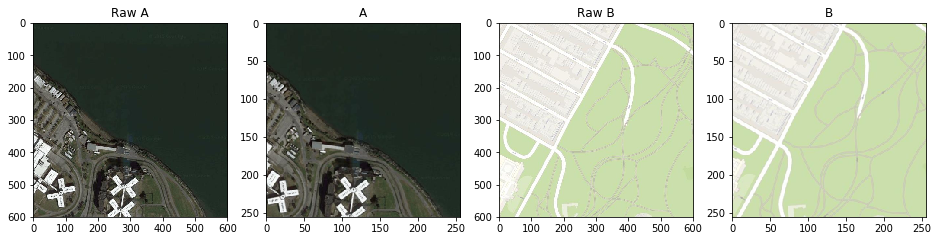

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def unnorm(x):
    un_x = 255*(x*0.5+0.5)
    return un_x.astype(np.uint8)

# visualize to check images
test_datum = next(iter(maps_dataloader))
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(test_datum['raw_A'][0].numpy())
plt.title('Raw A')
plt.subplot(1,4,2)
plt.imshow(unnorm(test_datum['A'][0].numpy()).transpose(1,2,0))
plt.title('A')
plt.subplot(1,4,3)
plt.imshow(test_datum['raw_B'][0].numpy())
plt.title('Raw B')
plt.subplot(1,4,4)
plt.imshow(unnorm(test_datum['B'][0].numpy()).transpose(1,2,0))
plt.title('B')

### Train

In [111]:
model = CycleGANModel()
model.initialize(isTrain=True)

---------- Networks initialized -------------
ResnetGenerator (
  (model): Sequential (
    (0): ReflectionPad2d (3, 3, 3, 3)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    (3): ReLU (inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (6): ReLU (inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (9): ReLU (inplace)
    (10): ResnetBlock (
      (conv_block): Sequential (
        (0): ReflectionPad2d (1, 1, 1, 1)
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
        (3): ReLU (inplace)
        (4): ReflectionPad2d (1, 1, 1, 1)
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): Inst

In [ ]:
from tqdm import tqdm_notebook
niter = 100 # number of iterations at starting learning rate
niter_decay = 100 # number of iterations to linearly decay learning rate to zero
epoch_progress_bar = tqdm_notebook(total=niter+niter_decay+1, desc='Total progress')
for epoch in range(1, niter+niter_decay+1):
    progress_bar = tqdm_notebook(total=len(maps_dataloader), desc='epoch '+str(epoch), leave=False)
    for i, data in enumerate(maps_dataloader):
        model.set_input(data)
        model.optimize_parameters()
        if i % 100 == 0:
            print('(epoch %d, iter %d): lossG %f, lossD_A %f, lossD_B %f' % (epoch, i, model.loss_G.data[0], model.loss_D_A.data[0], model.loss_D_B.data[0]))
            if i > 0:
                model.save('latest')
        progress_bar.update(1)
    if epoch > niter_decay:
        model.update_learning_rate(niter_decay)
    epoch_progress_bar.update(1)


(epoch 1, iter 0): lossG 2.636077, lossD_A 0.101981, lossD_B 0.205902
(epoch 1, iter 100): lossG 3.036292, lossD_A 0.064840, lossD_B 0.127950
(epoch 1, iter 200): lossG 2.651728, lossD_A 0.204895, lossD_B 0.190584
(epoch 1, iter 300): lossG 4.034714, lossD_A 0.165399, lossD_B 0.083002
(epoch 1, iter 400): lossG 3.072157, lossD_A 0.124268, lossD_B 0.145442
(epoch 1, iter 500): lossG 3.303264, lossD_A 0.105188, lossD_B 0.168636
(epoch 1, iter 600): lossG 3.816211, lossD_A 0.399649, lossD_B 0.177755
(epoch 1, iter 700): lossG 2.388910, lossD_A 0.166504, lossD_B 0.094071
(epoch 1, iter 800): lossG 3.951657, lossD_A 0.225194, lossD_B 0.186453
(epoch 1, iter 900): lossG 3.169069, lossD_A 0.138416, lossD_B 0.104453
(epoch 1, iter 1000): lossG 3.565406, lossD_A 0.014407, lossD_B 0.059743


(epoch 2, iter 0): lossG 2.490222, lossD_A 0.097117, lossD_B 0.128819
(epoch 2, iter 100): lossG 2.899707, lossD_A 0.059223, lossD_B 0.099755
(epoch 2, iter 200): lossG 2.297934, lossD_A 0.181214, lossD_B 0.051043
(epoch 2, iter 300): lossG 3.333260, lossD_A 0.119503, lossD_B 0.209538
(epoch 2, iter 400): lossG 4.858857, lossD_A 0.075732, lossD_B 0.056171
(epoch 2, iter 500): lossG 2.586762, lossD_A 0.251751, lossD_B 0.220116
(epoch 2, iter 600): lossG 3.288961, lossD_A 0.166470, lossD_B 0.185103
(epoch 2, iter 700): lossG 2.854129, lossD_A 0.091361, lossD_B 0.180610
(epoch 2, iter 800): lossG 3.103172, lossD_A 0.322113, lossD_B 0.232387
(epoch 2, iter 900): lossG 2.997650, lossD_A 0.036631, lossD_B 0.100610
(epoch 2, iter 1000): lossG 2.726433, lossD_A 0.063099, lossD_B 0.089531


(epoch 3, iter 0): lossG 3.109198, lossD_A 0.216928, lossD_B 0.218396
(epoch 3, iter 100): lossG 2.947299, lossD_A 0.145082, lossD_B 0.272876
(epoch 3, iter 200): lossG 3.215147, lossD_A 0.061227, lossD_B 0.187228
(epoch 3, iter 300): lossG 2.924899, lossD_A 0.064839, lossD_B 0.093984
(epoch 3, iter 400): lossG 3.849916, lossD_A 0.116165, lossD_B 0.110193
(epoch 3, iter 500): lossG 3.228843, lossD_A 0.110546, lossD_B 0.235845
(epoch 3, iter 600): lossG 4.484268, lossD_A 0.191160, lossD_B 0.102822
(epoch 3, iter 700): lossG 3.184188, lossD_A 0.051234, lossD_B 0.207775
(epoch 3, iter 800): lossG 2.621077, lossD_A 0.192199, lossD_B 0.302223
(epoch 3, iter 900): lossG 3.237728, lossD_A 0.147617, lossD_B 0.220546
(epoch 3, iter 1000): lossG 3.076499, lossD_A 0.097567, lossD_B 0.087733


(epoch 4, iter 0): lossG 2.968611, lossD_A 0.130531, lossD_B 0.113200
(epoch 4, iter 100): lossG 3.082429, lossD_A 0.125554, lossD_B 0.065866
(epoch 4, iter 200): lossG 3.511784, lossD_A 0.026357, lossD_B 0.298192
(epoch 4, iter 300): lossG 2.402703, lossD_A 0.104107, lossD_B 0.224149
(epoch 4, iter 400): lossG 3.200895, lossD_A 0.055254, lossD_B 0.242038
(epoch 4, iter 500): lossG 2.481311, lossD_A 0.091464, lossD_B 0.155702
(epoch 4, iter 600): lossG 4.206094, lossD_A 0.063944, lossD_B 0.193233
(epoch 4, iter 700): lossG 2.323821, lossD_A 0.075112, lossD_B 0.164772
(epoch 4, iter 800): lossG 3.910687, lossD_A 0.016704, lossD_B 0.260409
(epoch 4, iter 900): lossG 3.734071, lossD_A 0.063643, lossD_B 0.055018
(epoch 4, iter 1000): lossG 1.963484, lossD_A 0.092426, lossD_B 0.248335


(epoch 5, iter 0): lossG 2.112999, lossD_A 0.083318, lossD_B 0.270557
(epoch 5, iter 100): lossG 2.255711, lossD_A 0.120969, lossD_B 0.254420
(epoch 5, iter 200): lossG 3.838321, lossD_A 0.159720, lossD_B 0.316976
(epoch 5, iter 300): lossG 2.089946, lossD_A 0.163000, lossD_B 0.197322
(epoch 5, iter 400): lossG 3.260026, lossD_A 0.173416, lossD_B 0.170557
(epoch 5, iter 500): lossG 2.810236, lossD_A 0.118608, lossD_B 0.088122
(epoch 5, iter 600): lossG 2.961822, lossD_A 0.209051, lossD_B 0.223913
(epoch 5, iter 700): lossG 4.332600, lossD_A 0.257876, lossD_B 0.155890
(epoch 5, iter 800): lossG 2.269272, lossD_A 0.070474, lossD_B 0.157877
(epoch 5, iter 900): lossG 2.876507, lossD_A 0.198801, lossD_B 0.163791
(epoch 5, iter 1000): lossG 2.857551, lossD_A 0.126363, lossD_B 0.083289


(epoch 6, iter 0): lossG 2.656136, lossD_A 0.149832, lossD_B 0.113553
(epoch 6, iter 100): lossG 2.718485, lossD_A 0.014131, lossD_B 0.121117
(epoch 6, iter 200): lossG 2.682648, lossD_A 0.064979, lossD_B 0.144553
(epoch 6, iter 300): lossG 3.045845, lossD_A 0.043170, lossD_B 0.146014
(epoch 6, iter 400): lossG 2.269617, lossD_A 0.086344, lossD_B 0.239805
(epoch 6, iter 500): lossG 2.907357, lossD_A 0.087690, lossD_B 0.240342
(epoch 6, iter 600): lossG 1.880115, lossD_A 0.209883, lossD_B 0.121479
(epoch 6, iter 700): lossG 4.569999, lossD_A 0.066386, lossD_B 0.308516
(epoch 6, iter 800): lossG 2.603496, lossD_A 0.093463, lossD_B 0.066602
(epoch 6, iter 900): lossG 2.260497, lossD_A 0.202968, lossD_B 0.226789
(epoch 6, iter 1000): lossG 2.032527, lossD_A 0.221910, lossD_B 0.210945


(epoch 7, iter 0): lossG 2.581410, lossD_A 0.069289, lossD_B 0.120551
(epoch 7, iter 100): lossG 2.484577, lossD_A 0.124391, lossD_B 0.324805
(epoch 7, iter 200): lossG 2.559529, lossD_A 0.072071, lossD_B 0.203690
(epoch 7, iter 300): lossG 1.856626, lossD_A 0.131068, lossD_B 0.295567
(epoch 7, iter 400): lossG 3.208102, lossD_A 0.112936, lossD_B 0.144267
(epoch 7, iter 500): lossG 2.142639, lossD_A 0.083054, lossD_B 0.163007
(epoch 7, iter 600): lossG 2.411803, lossD_A 0.062061, lossD_B 0.091853
(epoch 7, iter 700): lossG 2.074127, lossD_A 0.033934, lossD_B 0.124050
(epoch 7, iter 800): lossG 3.376300, lossD_A 0.054543, lossD_B 0.070812
(epoch 7, iter 900): lossG 2.630982, lossD_A 0.075179, lossD_B 0.083999
(epoch 7, iter 1000): lossG 1.808774, lossD_A 0.245549, lossD_B 0.225414


(epoch 8, iter 0): lossG 2.929895, lossD_A 0.088714, lossD_B 0.028374
(epoch 8, iter 100): lossG 2.743061, lossD_A 0.226352, lossD_B 0.248858
(epoch 8, iter 200): lossG 3.696041, lossD_A 0.112737, lossD_B 0.191907
(epoch 8, iter 300): lossG 3.393412, lossD_A 0.120698, lossD_B 0.228490
(epoch 8, iter 400): lossG 2.194111, lossD_A 0.302667, lossD_B 0.025903
(epoch 8, iter 500): lossG 4.656832, lossD_A 0.102410, lossD_B 0.148095
(epoch 8, iter 600): lossG 2.438469, lossD_A 0.206225, lossD_B 0.048625
(epoch 8, iter 700): lossG 3.413027, lossD_A 0.055521, lossD_B 0.208004
(epoch 8, iter 800): lossG 2.888163, lossD_A 0.141315, lossD_B 0.347487
(epoch 8, iter 900): lossG 3.440434, lossD_A 0.125758, lossD_B 0.135403
(epoch 8, iter 1000): lossG 2.492664, lossD_A 0.157190, lossD_B 0.108495


(epoch 9, iter 0): lossG 2.725267, lossD_A 0.132740, lossD_B 0.028209
(epoch 9, iter 100): lossG 2.816722, lossD_A 0.138942, lossD_B 0.124082
(epoch 9, iter 200): lossG 3.502584, lossD_A 0.057876, lossD_B 0.033252
(epoch 9, iter 300): lossG 2.298862, lossD_A 0.112249, lossD_B 0.087149
(epoch 9, iter 400): lossG 2.761014, lossD_A 0.016360, lossD_B 0.074861
(epoch 9, iter 500): lossG 3.081973, lossD_A 0.043747, lossD_B 0.095659
(epoch 9, iter 600): lossG 3.104747, lossD_A 0.120488, lossD_B 0.145618
(epoch 9, iter 700): lossG 1.885746, lossD_A 0.350551, lossD_B 0.287948
(epoch 9, iter 800): lossG 1.941661, lossD_A 0.185659, lossD_B 0.120624
(epoch 9, iter 900): lossG 2.180694, lossD_A 0.154339, lossD_B 0.202962
(epoch 9, iter 1000): lossG 2.312345, lossD_A 0.140301, lossD_B 0.243482


(epoch 10, iter 0): lossG 2.550315, lossD_A 0.085837, lossD_B 0.238824
(epoch 10, iter 100): lossG 3.182607, lossD_A 0.086375, lossD_B 0.236396
(epoch 10, iter 200): lossG 1.772833, lossD_A 0.168929, lossD_B 0.103813
(epoch 10, iter 300): lossG 2.954842, lossD_A 0.115122, lossD_B 0.174876
(epoch 10, iter 400): lossG 2.743472, lossD_A 0.197647, lossD_B 0.241740
(epoch 10, iter 500): lossG 2.651565, lossD_A 0.133180, lossD_B 0.086828
(epoch 10, iter 600): lossG 2.259725, lossD_A 0.082473, lossD_B 0.170139
(epoch 10, iter 700): lossG 2.194291, lossD_A 0.057465, lossD_B 0.221076
(epoch 10, iter 800): lossG 3.339966, lossD_A 0.157655, lossD_B 0.091004
(epoch 10, iter 900): lossG 1.804929, lossD_A 0.122803, lossD_B 0.071846
(epoch 10, iter 1000): lossG 1.869419, lossD_A 0.090496, lossD_B 0.305010


(epoch 11, iter 0): lossG 3.680211, lossD_A 0.139921, lossD_B 0.258698
(epoch 11, iter 100): lossG 1.914400, lossD_A 0.134540, lossD_B 0.114886
(epoch 11, iter 200): lossG 2.691579, lossD_A 0.285709, lossD_B 0.066249
(epoch 11, iter 300): lossG 2.133339, lossD_A 0.053708, lossD_B 0.060597
(epoch 11, iter 400): lossG 2.274118, lossD_A 0.164933, lossD_B 0.136348
(epoch 11, iter 500): lossG 2.533589, lossD_A 0.258277, lossD_B 0.087225
(epoch 11, iter 600): lossG 2.358696, lossD_A 0.260003, lossD_B 0.454783
(epoch 11, iter 700): lossG 2.061797, lossD_A 0.212831, lossD_B 0.142261
(epoch 11, iter 800): lossG 2.593141, lossD_A 0.059458, lossD_B 0.288495
(epoch 11, iter 900): lossG 1.880029, lossD_A 0.108902, lossD_B 0.580600
(epoch 11, iter 1000): lossG 1.737935, lossD_A 0.111403, lossD_B 0.315899


(epoch 12, iter 0): lossG 2.440217, lossD_A 0.185790, lossD_B 0.179199
(epoch 12, iter 100): lossG 2.576341, lossD_A 0.265256, lossD_B 0.068279
(epoch 12, iter 200): lossG 1.773135, lossD_A 0.031970, lossD_B 0.292826
(epoch 12, iter 300): lossG 2.682512, lossD_A 0.341636, lossD_B 0.101173
(epoch 12, iter 400): lossG 1.858947, lossD_A 0.272473, lossD_B 0.237839
(epoch 12, iter 500): lossG 2.201997, lossD_A 0.178264, lossD_B 0.042557
(epoch 12, iter 600): lossG 2.876566, lossD_A 0.073744, lossD_B 0.099647
(epoch 12, iter 700): lossG 2.116507, lossD_A 0.359923, lossD_B 0.216806
(epoch 12, iter 800): lossG 2.491221, lossD_A 0.119925, lossD_B 0.134022
(epoch 12, iter 900): lossG 2.925280, lossD_A 0.223292, lossD_B 0.146677
(epoch 12, iter 1000): lossG 2.036638, lossD_A 0.037458, lossD_B 0.160621


(epoch 13, iter 0): lossG 2.250075, lossD_A 0.157001, lossD_B 0.351420
(epoch 13, iter 100): lossG 3.564976, lossD_A 0.040497, lossD_B 0.608713
(epoch 13, iter 200): lossG 3.245317, lossD_A 0.122720, lossD_B 0.093378
(epoch 13, iter 300): lossG 1.912840, lossD_A 0.253154, lossD_B 0.165201
(epoch 13, iter 400): lossG 2.190953, lossD_A 0.574780, lossD_B 0.115671
(epoch 13, iter 500): lossG 1.798105, lossD_A 0.234645, lossD_B 0.052793
(epoch 13, iter 600): lossG 2.225782, lossD_A 0.069006, lossD_B 0.123700
(epoch 13, iter 700): lossG 1.828248, lossD_A 0.362414, lossD_B 0.216543
(epoch 13, iter 800): lossG 1.939041, lossD_A 0.293868, lossD_B 0.200734
(epoch 13, iter 900): lossG 2.743690, lossD_A 0.202050, lossD_B 0.169412
(epoch 13, iter 1000): lossG 2.240060, lossD_A 0.047447, lossD_B 0.258316


(epoch 14, iter 0): lossG 2.338899, lossD_A 0.051461, lossD_B 0.124975
(epoch 14, iter 100): lossG 2.386997, lossD_A 0.151994, lossD_B 0.100213
(epoch 14, iter 200): lossG 2.283380, lossD_A 0.216440, lossD_B 0.172557
(epoch 14, iter 300): lossG 2.448127, lossD_A 0.261576, lossD_B 0.258531
(epoch 14, iter 400): lossG 2.898322, lossD_A 0.081990, lossD_B 0.136170
(epoch 14, iter 500): lossG 2.469598, lossD_A 0.103121, lossD_B 0.083060
(epoch 14, iter 600): lossG 2.140676, lossD_A 0.301016, lossD_B 0.164498
(epoch 14, iter 700): lossG 1.391433, lossD_A 0.167583, lossD_B 0.068914
(epoch 14, iter 800): lossG 2.190073, lossD_A 0.121683, lossD_B 0.159595
(epoch 14, iter 900): lossG 2.623542, lossD_A 0.262402, lossD_B 0.067858
(epoch 14, iter 1000): lossG 1.935760, lossD_A 0.249249, lossD_B 0.138238


(epoch 15, iter 0): lossG 2.238220, lossD_A 0.071170, lossD_B 0.104205
(epoch 15, iter 100): lossG 1.757500, lossD_A 0.213339, lossD_B 0.232064
(epoch 15, iter 200): lossG 2.353848, lossD_A 0.110219, lossD_B 0.135562
(epoch 15, iter 300): lossG 2.606965, lossD_A 0.108514, lossD_B 0.132161
(epoch 15, iter 400): lossG 2.462319, lossD_A 0.174512, lossD_B 0.230762
(epoch 15, iter 500): lossG 2.755263, lossD_A 0.176932, lossD_B 0.160415
(epoch 15, iter 600): lossG 3.535079, lossD_A 0.297791, lossD_B 0.172924
(epoch 15, iter 700): lossG 1.746626, lossD_A 0.077849, lossD_B 0.276122
(epoch 15, iter 800): lossG 2.013104, lossD_A 0.057422, lossD_B 0.111994
(epoch 15, iter 900): lossG 3.133460, lossD_A 0.049048, lossD_B 0.197236
(epoch 15, iter 1000): lossG 2.665524, lossD_A 0.130427, lossD_B 0.068708


(epoch 16, iter 0): lossG 2.500754, lossD_A 0.098223, lossD_B 0.075540
(epoch 16, iter 100): lossG 1.746041, lossD_A 0.093434, lossD_B 0.194921
(epoch 16, iter 200): lossG 2.138129, lossD_A 0.160624, lossD_B 0.062460
(epoch 16, iter 300): lossG 2.294916, lossD_A 0.144531, lossD_B 0.115679
(epoch 16, iter 400): lossG 1.893675, lossD_A 0.136607, lossD_B 0.075656
(epoch 16, iter 500): lossG 1.891274, lossD_A 0.397409, lossD_B 0.340887
(epoch 16, iter 600): lossG 2.304051, lossD_A 0.066456, lossD_B 0.163803
(epoch 16, iter 700): lossG 3.222939, lossD_A 0.078349, lossD_B 0.045751
(epoch 16, iter 800): lossG 2.566830, lossD_A 0.222056, lossD_B 0.149795
(epoch 16, iter 900): lossG 2.713626, lossD_A 0.106349, lossD_B 0.109248
(epoch 16, iter 1000): lossG 2.313542, lossD_A 0.136934, lossD_B 0.195319


(epoch 17, iter 0): lossG 1.988963, lossD_A 0.197304, lossD_B 0.184556
(epoch 17, iter 100): lossG 2.962777, lossD_A 0.096509, lossD_B 0.203243
(epoch 17, iter 200): lossG 1.991274, lossD_A 0.308308, lossD_B 0.043622
(epoch 17, iter 300): lossG 2.080880, lossD_A 0.257347, lossD_B 0.235635
(epoch 17, iter 400): lossG 2.292242, lossD_A 0.256087, lossD_B 0.211094
(epoch 17, iter 500): lossG 1.712133, lossD_A 0.221105, lossD_B 0.168852
(epoch 17, iter 600): lossG 2.311485, lossD_A 0.079851, lossD_B 0.152281
(epoch 17, iter 700): lossG 2.369543, lossD_A 0.130865, lossD_B 0.074019
(epoch 17, iter 800): lossG 3.005337, lossD_A 0.104653, lossD_B 0.222149
(epoch 17, iter 900): lossG 2.352294, lossD_A 0.125317, lossD_B 0.367117
(epoch 17, iter 1000): lossG 2.583430, lossD_A 0.210158, lossD_B 0.255395


(epoch 18, iter 0): lossG 1.918601, lossD_A 0.081567, lossD_B 0.071602
(epoch 18, iter 100): lossG 1.975380, lossD_A 0.184319, lossD_B 0.150062
(epoch 18, iter 200): lossG 1.711477, lossD_A 0.351383, lossD_B 0.099330
(epoch 18, iter 300): lossG 2.348311, lossD_A 0.202871, lossD_B 0.164206
(epoch 18, iter 400): lossG 1.677830, lossD_A 0.126728, lossD_B 0.295036
(epoch 18, iter 500): lossG 2.191269, lossD_A 0.110474, lossD_B 0.147701
(epoch 18, iter 600): lossG 1.606284, lossD_A 0.122521, lossD_B 0.305491
(epoch 18, iter 700): lossG 2.440042, lossD_A 0.105270, lossD_B 0.137006
(epoch 18, iter 800): lossG 2.337196, lossD_A 0.081115, lossD_B 0.195156
(epoch 18, iter 900): lossG 2.409775, lossD_A 0.047585, lossD_B 0.270043
(epoch 18, iter 1000): lossG 1.699811, lossD_A 0.136116, lossD_B 0.267053


(epoch 19, iter 0): lossG 3.560746, lossD_A 0.029099, lossD_B 0.086145
(epoch 19, iter 100): lossG 2.839169, lossD_A 0.050480, lossD_B 0.074802
(epoch 19, iter 200): lossG 3.037596, lossD_A 0.103010, lossD_B 0.058353
(epoch 19, iter 300): lossG 2.417362, lossD_A 0.034745, lossD_B 0.156326
(epoch 19, iter 400): lossG 1.928918, lossD_A 0.104116, lossD_B 0.156192
(epoch 19, iter 500): lossG 2.773281, lossD_A 0.231464, lossD_B 0.236928
(epoch 19, iter 600): lossG 2.245655, lossD_A 0.161927, lossD_B 0.084426
(epoch 19, iter 700): lossG 1.755312, lossD_A 0.185515, lossD_B 0.261548
(epoch 19, iter 800): lossG 1.833330, lossD_A 0.172835, lossD_B 0.233936
(epoch 19, iter 900): lossG 3.010665, lossD_A 0.208673, lossD_B 0.174240
(epoch 19, iter 1000): lossG 2.898489, lossD_A 0.073955, lossD_B 0.380786


(epoch 20, iter 0): lossG 2.916944, lossD_A 0.221810, lossD_B 0.265571
(epoch 20, iter 100): lossG 2.648677, lossD_A 0.166515, lossD_B 0.185985
(epoch 20, iter 200): lossG 2.003422, lossD_A 0.187451, lossD_B 0.196172
(epoch 20, iter 300): lossG 2.198528, lossD_A 0.113876, lossD_B 0.152142
(epoch 20, iter 400): lossG 1.965014, lossD_A 0.192543, lossD_B 0.257690
(epoch 20, iter 500): lossG 1.795787, lossD_A 0.252308, lossD_B 0.100261
(epoch 20, iter 600): lossG 1.085863, lossD_A 0.173463, lossD_B 0.354158
(epoch 20, iter 700): lossG 2.595331, lossD_A 0.051018, lossD_B 0.191840
(epoch 20, iter 800): lossG 2.649835, lossD_A 0.186922, lossD_B 0.304596
(epoch 20, iter 900): lossG 2.393883, lossD_A 0.188322, lossD_B 0.523986
(epoch 20, iter 1000): lossG 2.823240, lossD_A 0.066895, lossD_B 0.180611


(epoch 21, iter 0): lossG 2.137576, lossD_A 0.120870, lossD_B 0.175409
(epoch 21, iter 100): lossG 2.257216, lossD_A 0.075613, lossD_B 0.121311
(epoch 21, iter 200): lossG 2.134327, lossD_A 0.059790, lossD_B 0.124445
(epoch 21, iter 300): lossG 1.544067, lossD_A 0.429867, lossD_B 0.281477
(epoch 21, iter 400): lossG 2.179233, lossD_A 0.187650, lossD_B 0.205143
(epoch 21, iter 500): lossG 2.659003, lossD_A 0.037245, lossD_B 0.039967
(epoch 21, iter 600): lossG 2.208543, lossD_A 0.246190, lossD_B 0.230133
(epoch 21, iter 700): lossG 1.643743, lossD_A 0.194832, lossD_B 0.257737
(epoch 21, iter 800): lossG 1.916631, lossD_A 0.189539, lossD_B 0.082668
(epoch 21, iter 900): lossG 2.631688, lossD_A 0.073165, lossD_B 0.249876
(epoch 21, iter 1000): lossG 2.815580, lossD_A 0.182752, lossD_B 0.193383


(epoch 22, iter 0): lossG 1.863924, lossD_A 0.057300, lossD_B 0.208777
(epoch 22, iter 100): lossG 1.895093, lossD_A 0.092592, lossD_B 0.482186
(epoch 22, iter 200): lossG 1.917275, lossD_A 0.111940, lossD_B 0.284093
(epoch 22, iter 300): lossG 1.702877, lossD_A 0.289232, lossD_B 0.136923
(epoch 22, iter 400): lossG 2.000779, lossD_A 0.224945, lossD_B 0.227341
(epoch 22, iter 500): lossG 1.772743, lossD_A 0.078636, lossD_B 0.208994
(epoch 22, iter 600): lossG 2.485816, lossD_A 0.047239, lossD_B 0.114367
(epoch 22, iter 700): lossG 1.856411, lossD_A 0.137043, lossD_B 0.321837
(epoch 22, iter 800): lossG 1.847505, lossD_A 0.122652, lossD_B 0.286462
(epoch 22, iter 900): lossG 1.651559, lossD_A 0.130695, lossD_B 0.228015
(epoch 22, iter 1000): lossG 1.982007, lossD_A 0.189002, lossD_B 0.084030


(epoch 23, iter 0): lossG 2.332274, lossD_A 0.064353, lossD_B 0.158870
(epoch 23, iter 100): lossG 2.604247, lossD_A 0.256077, lossD_B 0.192396
(epoch 23, iter 200): lossG 1.939138, lossD_A 0.036485, lossD_B 0.257840
(epoch 23, iter 300): lossG 1.467304, lossD_A 0.109348, lossD_B 0.425429
(epoch 23, iter 400): lossG 1.943343, lossD_A 0.149726, lossD_B 0.107576
(epoch 23, iter 500): lossG 2.472866, lossD_A 0.102366, lossD_B 0.248778
(epoch 23, iter 600): lossG 3.428490, lossD_A 0.183051, lossD_B 0.139046
(epoch 23, iter 700): lossG 2.158294, lossD_A 0.106619, lossD_B 0.259711
(epoch 23, iter 800): lossG 2.440934, lossD_A 0.027166, lossD_B 0.102549
(epoch 23, iter 900): lossG 1.609053, lossD_A 0.269168, lossD_B 0.248836
(epoch 23, iter 1000): lossG 2.108860, lossD_A 0.104120, lossD_B 0.127453


(epoch 24, iter 0): lossG 2.647311, lossD_A 0.224592, lossD_B 0.133939
(epoch 24, iter 100): lossG 2.641265, lossD_A 0.167874, lossD_B 0.128967
(epoch 24, iter 200): lossG 2.245327, lossD_A 0.116701, lossD_B 0.084256
(epoch 24, iter 300): lossG 1.683135, lossD_A 0.221325, lossD_B 0.111814
(epoch 24, iter 400): lossG 2.181446, lossD_A 0.192873, lossD_B 0.153713
(epoch 24, iter 500): lossG 2.498052, lossD_A 0.111596, lossD_B 0.073416
(epoch 24, iter 600): lossG 2.385938, lossD_A 0.064717, lossD_B 0.150450
(epoch 24, iter 700): lossG 3.052559, lossD_A 0.047592, lossD_B 0.207162
(epoch 24, iter 800): lossG 3.252699, lossD_A 0.407032, lossD_B 0.183548
(epoch 24, iter 900): lossG 1.469890, lossD_A 0.081393, lossD_B 0.119003
(epoch 24, iter 1000): lossG 1.909397, lossD_A 0.175084, lossD_B 0.337072


(epoch 25, iter 0): lossG 2.107002, lossD_A 0.029116, lossD_B 0.244451
(epoch 25, iter 100): lossG 2.178784, lossD_A 0.089267, lossD_B 0.137932
(epoch 25, iter 200): lossG 2.435865, lossD_A 0.096896, lossD_B 0.106923
(epoch 25, iter 300): lossG 2.274104, lossD_A 0.243517, lossD_B 0.066104
(epoch 25, iter 400): lossG 2.299850, lossD_A 0.035466, lossD_B 0.154214
(epoch 25, iter 500): lossG 1.932456, lossD_A 0.056948, lossD_B 0.222020
(epoch 25, iter 600): lossG 2.401023, lossD_A 0.167335, lossD_B 0.265251
(epoch 25, iter 700): lossG 2.696760, lossD_A 0.276018, lossD_B 0.189328
(epoch 25, iter 800): lossG 2.014390, lossD_A 0.040093, lossD_B 0.163197
(epoch 25, iter 900): lossG 2.689270, lossD_A 0.136458, lossD_B 0.195687
(epoch 25, iter 1000): lossG 1.860499, lossD_A 0.403369, lossD_B 0.072572


(epoch 26, iter 0): lossG 2.280788, lossD_A 0.118003, lossD_B 0.153509
(epoch 26, iter 100): lossG 2.815177, lossD_A 0.137408, lossD_B 0.123877
(epoch 26, iter 200): lossG 1.548958, lossD_A 0.208922, lossD_B 0.191898
(epoch 26, iter 300): lossG 2.738744, lossD_A 0.180209, lossD_B 0.198976
(epoch 26, iter 400): lossG 1.862414, lossD_A 0.111888, lossD_B 0.175338
(epoch 26, iter 500): lossG 1.965744, lossD_A 0.229898, lossD_B 0.116899
(epoch 26, iter 600): lossG 1.888452, lossD_A 0.109548, lossD_B 0.301964
(epoch 26, iter 700): lossG 2.412497, lossD_A 0.075101, lossD_B 0.195116
(epoch 26, iter 800): lossG 1.890890, lossD_A 0.058017, lossD_B 0.176793
(epoch 26, iter 900): lossG 3.069943, lossD_A 0.022596, lossD_B 0.104693
(epoch 26, iter 1000): lossG 1.950754, lossD_A 0.210950, lossD_B 0.072592


(epoch 27, iter 0): lossG 2.725062, lossD_A 0.244656, lossD_B 0.137400
(epoch 27, iter 100): lossG 2.247747, lossD_A 0.087023, lossD_B 0.214595
(epoch 27, iter 200): lossG 1.486240, lossD_A 0.097019, lossD_B 0.108310
(epoch 27, iter 300): lossG 1.994220, lossD_A 0.188588, lossD_B 0.201389
(epoch 27, iter 400): lossG 2.004972, lossD_A 0.265581, lossD_B 0.094596
(epoch 27, iter 500): lossG 1.604177, lossD_A 0.240751, lossD_B 0.249544
(epoch 27, iter 600): lossG 1.788649, lossD_A 0.232798, lossD_B 0.170685
(epoch 27, iter 700): lossG 1.998740, lossD_A 0.167275, lossD_B 0.154949
(epoch 27, iter 800): lossG 2.303834, lossD_A 0.144557, lossD_B 0.198436
(epoch 27, iter 900): lossG 1.871283, lossD_A 0.201543, lossD_B 0.084716
(epoch 27, iter 1000): lossG 2.011697, lossD_A 0.096197, lossD_B 0.281268


(epoch 28, iter 0): lossG 1.821142, lossD_A 0.360614, lossD_B 0.208105
(epoch 28, iter 100): lossG 2.221756, lossD_A 0.161283, lossD_B 0.300425
(epoch 28, iter 200): lossG 2.036263, lossD_A 0.218512, lossD_B 0.072828
(epoch 28, iter 300): lossG 1.801677, lossD_A 0.108757, lossD_B 0.062195
(epoch 28, iter 400): lossG 2.322426, lossD_A 0.031161, lossD_B 0.186656
(epoch 28, iter 500): lossG 2.254307, lossD_A 0.221254, lossD_B 0.199477
(epoch 28, iter 600): lossG 4.446827, lossD_A 0.191157, lossD_B 0.189859
(epoch 28, iter 700): lossG 2.077847, lossD_A 0.121627, lossD_B 0.217165
(epoch 28, iter 800): lossG 1.520982, lossD_A 0.433228, lossD_B 0.260168
(epoch 28, iter 900): lossG 1.760218, lossD_A 0.134138, lossD_B 0.382178
(epoch 28, iter 1000): lossG 2.149570, lossD_A 0.253527, lossD_B 0.277481


(epoch 29, iter 0): lossG 2.157819, lossD_A 0.332543, lossD_B 0.227899
(epoch 29, iter 100): lossG 2.783394, lossD_A 0.161480, lossD_B 0.162828
(epoch 29, iter 200): lossG 2.385908, lossD_A 0.139906, lossD_B 0.188828
(epoch 29, iter 300): lossG 2.660316, lossD_A 0.037489, lossD_B 0.141874
(epoch 29, iter 400): lossG 2.169842, lossD_A 0.166196, lossD_B 0.229582
(epoch 29, iter 500): lossG 1.567146, lossD_A 0.274430, lossD_B 0.117875
(epoch 29, iter 600): lossG 1.816562, lossD_A 0.170925, lossD_B 0.308842
(epoch 29, iter 700): lossG 2.351902, lossD_A 0.043881, lossD_B 0.041721
(epoch 29, iter 800): lossG 2.878996, lossD_A 0.202881, lossD_B 0.201418
(epoch 29, iter 900): lossG 2.236259, lossD_A 0.235292, lossD_B 0.089854
(epoch 29, iter 1000): lossG 1.768578, lossD_A 0.089225, lossD_B 0.213310


(epoch 30, iter 0): lossG 1.718282, lossD_A 0.156979, lossD_B 0.123296
(epoch 30, iter 100): lossG 2.187099, lossD_A 0.130020, lossD_B 0.301518
(epoch 30, iter 200): lossG 1.464636, lossD_A 0.078515, lossD_B 0.160961
(epoch 30, iter 300): lossG 2.101438, lossD_A 0.206106, lossD_B 0.356843
(epoch 30, iter 400): lossG 1.681086, lossD_A 0.047110, lossD_B 0.372826
(epoch 30, iter 500): lossG 2.571720, lossD_A 0.203269, lossD_B 0.175815
(epoch 30, iter 600): lossG 2.347691, lossD_A 0.068226, lossD_B 0.149361
(epoch 30, iter 700): lossG 2.080832, lossD_A 0.188774, lossD_B 0.164978
(epoch 30, iter 800): lossG 1.814300, lossD_A 0.275983, lossD_B 0.199435
(epoch 30, iter 900): lossG 2.664516, lossD_A 0.077489, lossD_B 0.164951
(epoch 30, iter 1000): lossG 2.143219, lossD_A 0.028529, lossD_B 0.216424


(epoch 31, iter 0): lossG 3.049145, lossD_A 0.110824, lossD_B 0.073430
(epoch 31, iter 100): lossG 2.349468, lossD_A 0.107997, lossD_B 0.143682
(epoch 31, iter 200): lossG 2.174205, lossD_A 0.183521, lossD_B 0.234560
(epoch 31, iter 300): lossG 1.722440, lossD_A 0.408143, lossD_B 0.277203
(epoch 31, iter 400): lossG 2.949945, lossD_A 0.207708, lossD_B 0.249949
(epoch 31, iter 500): lossG 1.399786, lossD_A 0.268328, lossD_B 0.279464
(epoch 31, iter 600): lossG 2.150937, lossD_A 0.302895, lossD_B 0.087544
(epoch 31, iter 700): lossG 2.306050, lossD_A 0.180130, lossD_B 0.229803
(epoch 31, iter 800): lossG 1.860995, lossD_A 0.060649, lossD_B 0.234386
(epoch 31, iter 900): lossG 2.679600, lossD_A 0.076129, lossD_B 0.107574
(epoch 31, iter 1000): lossG 3.124583, lossD_A 0.043559, lossD_B 0.120832


(epoch 32, iter 0): lossG 2.102951, lossD_A 0.175702, lossD_B 0.327381
(epoch 32, iter 100): lossG 1.860758, lossD_A 0.121211, lossD_B 0.158897
(epoch 32, iter 200): lossG 2.087744, lossD_A 0.082408, lossD_B 0.088439
(epoch 32, iter 300): lossG 2.326480, lossD_A 0.114072, lossD_B 0.174682
(epoch 32, iter 400): lossG 1.279568, lossD_A 0.275135, lossD_B 0.120487
(epoch 32, iter 500): lossG 1.871165, lossD_A 0.135925, lossD_B 0.186195
(epoch 32, iter 600): lossG 1.721973, lossD_A 0.216484, lossD_B 0.125987
(epoch 32, iter 700): lossG 2.239357, lossD_A 0.230197, lossD_B 0.092947
(epoch 32, iter 800): lossG 2.152716, lossD_A 0.132908, lossD_B 0.107851
(epoch 32, iter 900): lossG 2.499091, lossD_A 0.092067, lossD_B 0.127054
(epoch 32, iter 1000): lossG 1.958521, lossD_A 0.089016, lossD_B 0.184056


(epoch 33, iter 0): lossG 1.938734, lossD_A 0.129310, lossD_B 0.213010
(epoch 33, iter 100): lossG 2.064727, lossD_A 0.106331, lossD_B 0.039769
(epoch 33, iter 200): lossG 1.720385, lossD_A 0.159155, lossD_B 0.192182
(epoch 33, iter 300): lossG 2.062685, lossD_A 0.190522, lossD_B 0.224964
(epoch 33, iter 400): lossG 1.970141, lossD_A 0.050535, lossD_B 0.150388
(epoch 33, iter 500): lossG 1.958541, lossD_A 0.130240, lossD_B 0.077127
(epoch 33, iter 600): lossG 1.685913, lossD_A 0.099198, lossD_B 0.101232
(epoch 33, iter 700): lossG 2.268254, lossD_A 0.039270, lossD_B 0.257521
(epoch 33, iter 800): lossG 2.081335, lossD_A 0.014874, lossD_B 0.096067
(epoch 33, iter 900): lossG 1.538940, lossD_A 0.433546, lossD_B 0.311004
(epoch 33, iter 1000): lossG 2.726763, lossD_A 0.124637, lossD_B 0.234507


(epoch 34, iter 0): lossG 2.370731, lossD_A 0.214177, lossD_B 0.134132
(epoch 34, iter 100): lossG 2.360584, lossD_A 0.083122, lossD_B 0.239233
(epoch 34, iter 200): lossG 2.002912, lossD_A 0.142494, lossD_B 0.299341
(epoch 34, iter 300): lossG 2.547054, lossD_A 0.141561, lossD_B 0.084032
(epoch 34, iter 400): lossG 2.275207, lossD_A 0.129573, lossD_B 0.085632
(epoch 34, iter 500): lossG 2.677938, lossD_A 0.058680, lossD_B 0.171364
(epoch 34, iter 600): lossG 1.958972, lossD_A 0.203386, lossD_B 0.134182
(epoch 34, iter 700): lossG 2.075882, lossD_A 0.064776, lossD_B 0.188955
(epoch 34, iter 800): lossG 2.089365, lossD_A 0.172989, lossD_B 0.274046
(epoch 34, iter 900): lossG 2.308915, lossD_A 0.140582, lossD_B 0.136776
(epoch 34, iter 1000): lossG 2.677312, lossD_A 0.040709, lossD_B 0.133090


(epoch 35, iter 0): lossG 1.156519, lossD_A 0.387085, lossD_B 0.231795
(epoch 35, iter 100): lossG 2.811223, lossD_A 0.053838, lossD_B 0.092526
(epoch 35, iter 200): lossG 2.032208, lossD_A 0.304136, lossD_B 0.257090
(epoch 35, iter 300): lossG 1.370832, lossD_A 0.205833, lossD_B 0.131412
(epoch 35, iter 400): lossG 2.197007, lossD_A 0.055610, lossD_B 0.113935
(epoch 35, iter 500): lossG 1.657158, lossD_A 0.217581, lossD_B 0.261040
(epoch 35, iter 600): lossG 2.311972, lossD_A 0.207570, lossD_B 0.127191
(epoch 35, iter 700): lossG 1.508817, lossD_A 0.202540, lossD_B 0.253082
(epoch 35, iter 800): lossG 2.560434, lossD_A 0.129648, lossD_B 0.174047
(epoch 35, iter 900): lossG 2.117226, lossD_A 0.074680, lossD_B 0.278201
(epoch 35, iter 1000): lossG 2.653576, lossD_A 0.092661, lossD_B 0.246130


(epoch 36, iter 0): lossG 1.809048, lossD_A 0.120953, lossD_B 0.182315
(epoch 36, iter 100): lossG 2.370123, lossD_A 0.067214, lossD_B 0.294433
(epoch 36, iter 200): lossG 2.062820, lossD_A 0.087656, lossD_B 0.206717
(epoch 36, iter 300): lossG 2.195127, lossD_A 0.094578, lossD_B 0.283067
(epoch 36, iter 400): lossG 2.689895, lossD_A 0.037835, lossD_B 0.152181
(epoch 36, iter 500): lossG 1.790789, lossD_A 0.095414, lossD_B 0.113674
(epoch 36, iter 600): lossG 1.919467, lossD_A 0.289061, lossD_B 0.303539
(epoch 36, iter 700): lossG 2.475647, lossD_A 0.177955, lossD_B 0.184280
(epoch 36, iter 800): lossG 1.736101, lossD_A 0.208737, lossD_B 0.289649
(epoch 36, iter 900): lossG 1.836530, lossD_A 0.054877, lossD_B 0.149431
(epoch 36, iter 1000): lossG 1.724959, lossD_A 0.074648, lossD_B 0.394266


(epoch 37, iter 0): lossG 2.102492, lossD_A 0.154413, lossD_B 0.132647
(epoch 37, iter 100): lossG 1.733286, lossD_A 0.078238, lossD_B 0.193266
(epoch 37, iter 200): lossG 1.537560, lossD_A 0.084714, lossD_B 0.204361
(epoch 37, iter 300): lossG 1.473620, lossD_A 0.062194, lossD_B 0.230352
(epoch 37, iter 400): lossG 1.474345, lossD_A 0.055961, lossD_B 0.084032
(epoch 37, iter 500): lossG 2.364598, lossD_A 0.127050, lossD_B 0.170396
(epoch 37, iter 600): lossG 2.492203, lossD_A 0.073280, lossD_B 0.126615
(epoch 37, iter 700): lossG 2.281887, lossD_A 0.209396, lossD_B 0.208525
(epoch 37, iter 800): lossG 2.583807, lossD_A 0.146721, lossD_B 0.063610
(epoch 37, iter 900): lossG 2.199941, lossD_A 0.066736, lossD_B 0.259548
(epoch 37, iter 1000): lossG 2.454885, lossD_A 0.122029, lossD_B 0.073140


(epoch 38, iter 0): lossG 2.279683, lossD_A 0.220227, lossD_B 0.411312
(epoch 38, iter 100): lossG 1.874871, lossD_A 0.072749, lossD_B 0.091784
(epoch 38, iter 200): lossG 2.998213, lossD_A 0.038288, lossD_B 0.219511
(epoch 38, iter 300): lossG 2.227799, lossD_A 0.022922, lossD_B 0.136506
(epoch 38, iter 400): lossG 1.541750, lossD_A 0.199501, lossD_B 0.371523
(epoch 38, iter 500): lossG 1.720284, lossD_A 0.182566, lossD_B 0.229090
(epoch 38, iter 600): lossG 2.232615, lossD_A 0.301452, lossD_B 0.056784
(epoch 38, iter 700): lossG 2.547709, lossD_A 0.112756, lossD_B 0.301665
(epoch 38, iter 800): lossG 1.887817, lossD_A 0.058163, lossD_B 0.140702
(epoch 38, iter 900): lossG 1.812137, lossD_A 0.054743, lossD_B 0.178645
(epoch 38, iter 1000): lossG 1.802969, lossD_A 0.238594, lossD_B 0.284585


(epoch 39, iter 0): lossG 2.802710, lossD_A 0.028559, lossD_B 0.176575
(epoch 39, iter 100): lossG 1.507998, lossD_A 0.465130, lossD_B 0.230716
(epoch 39, iter 200): lossG 2.905182, lossD_A 0.117822, lossD_B 0.087858
(epoch 39, iter 300): lossG 1.749262, lossD_A 0.155974, lossD_B 0.350685
(epoch 39, iter 400): lossG 1.840330, lossD_A 0.185883, lossD_B 0.243918
(epoch 39, iter 500): lossG 2.071297, lossD_A 0.172379, lossD_B 0.169900
(epoch 39, iter 600): lossG 2.090710, lossD_A 0.061511, lossD_B 0.183820
(epoch 39, iter 700): lossG 1.447621, lossD_A 0.253489, lossD_B 0.186266
(epoch 39, iter 800): lossG 2.569318, lossD_A 0.182053, lossD_B 0.251282
(epoch 39, iter 900): lossG 1.415096, lossD_A 0.145515, lossD_B 0.222082
(epoch 39, iter 1000): lossG 2.227936, lossD_A 0.145204, lossD_B 0.108296


(epoch 40, iter 0): lossG 1.500178, lossD_A 0.178352, lossD_B 0.254882
(epoch 40, iter 100): lossG 1.480144, lossD_A 0.137754, lossD_B 0.374319
(epoch 40, iter 200): lossG 2.430922, lossD_A 0.048050, lossD_B 0.183969
(epoch 40, iter 300): lossG 2.075690, lossD_A 0.045652, lossD_B 0.220770
(epoch 40, iter 400): lossG 1.388106, lossD_A 0.125127, lossD_B 0.080468
(epoch 40, iter 500): lossG 1.847280, lossD_A 0.119623, lossD_B 0.141769
(epoch 40, iter 600): lossG 1.190824, lossD_A 0.508208, lossD_B 0.086360
(epoch 40, iter 700): lossG 1.466952, lossD_A 0.116850, lossD_B 0.142074
(epoch 40, iter 800): lossG 2.942414, lossD_A 0.140702, lossD_B 0.116430
(epoch 40, iter 900): lossG 2.087432, lossD_A 0.183042, lossD_B 0.241381
(epoch 40, iter 1000): lossG 2.109900, lossD_A 0.102364, lossD_B 0.111510


(epoch 41, iter 0): lossG 1.880223, lossD_A 0.112111, lossD_B 0.082859
(epoch 41, iter 100): lossG 1.992562, lossD_A 0.076874, lossD_B 0.266475
(epoch 41, iter 200): lossG 1.485483, lossD_A 0.111933, lossD_B 0.155231
(epoch 41, iter 300): lossG 2.430799, lossD_A 0.112321, lossD_B 0.353191
(epoch 41, iter 400): lossG 2.378527, lossD_A 0.081379, lossD_B 0.199091
(epoch 41, iter 500): lossG 2.477933, lossD_A 0.172896, lossD_B 0.251721
(epoch 41, iter 600): lossG 1.914217, lossD_A 0.033147, lossD_B 0.169245
(epoch 41, iter 700): lossG 1.857479, lossD_A 0.097195, lossD_B 0.138451
(epoch 41, iter 800): lossG 1.940077, lossD_A 0.357154, lossD_B 0.332711
(epoch 41, iter 900): lossG 1.718187, lossD_A 0.222555, lossD_B 0.070449
(epoch 41, iter 1000): lossG 1.832464, lossD_A 0.131706, lossD_B 0.109574


(epoch 42, iter 0): lossG 1.747491, lossD_A 0.220255, lossD_B 0.374227
(epoch 42, iter 100): lossG 1.488646, lossD_A 0.110139, lossD_B 0.336053
(epoch 42, iter 200): lossG 2.069948, lossD_A 0.097468, lossD_B 0.196064
(epoch 42, iter 300): lossG 1.716018, lossD_A 0.084431, lossD_B 0.109795
(epoch 42, iter 400): lossG 1.568582, lossD_A 0.188078, lossD_B 0.183474
(epoch 42, iter 500): lossG 2.466365, lossD_A 0.096557, lossD_B 0.083925
(epoch 42, iter 600): lossG 2.184655, lossD_A 0.078529, lossD_B 0.142107
(epoch 42, iter 700): lossG 2.002652, lossD_A 0.071447, lossD_B 0.146024
(epoch 42, iter 800): lossG 2.028661, lossD_A 0.097010, lossD_B 0.216029
(epoch 42, iter 900): lossG 2.180304, lossD_A 0.137870, lossD_B 0.146439
(epoch 42, iter 1000): lossG 1.805152, lossD_A 0.361365, lossD_B 0.156553


(epoch 43, iter 0): lossG 1.539906, lossD_A 0.207299, lossD_B 0.050518
(epoch 43, iter 100): lossG 3.601400, lossD_A 0.260399, lossD_B 0.204046
(epoch 43, iter 200): lossG 2.166157, lossD_A 0.204954, lossD_B 0.175675
(epoch 43, iter 300): lossG 1.903377, lossD_A 0.214123, lossD_B 0.159362
(epoch 43, iter 400): lossG 3.327934, lossD_A 0.109903, lossD_B 0.251208
(epoch 43, iter 500): lossG 2.322996, lossD_A 0.117483, lossD_B 0.180903
(epoch 43, iter 600): lossG 2.226792, lossD_A 0.113721, lossD_B 0.123196
(epoch 43, iter 700): lossG 2.043190, lossD_A 0.163481, lossD_B 0.143807
(epoch 43, iter 800): lossG 1.658093, lossD_A 0.201936, lossD_B 0.141907
(epoch 43, iter 900): lossG 1.971673, lossD_A 0.165344, lossD_B 0.119031
(epoch 43, iter 1000): lossG 2.246502, lossD_A 0.153029, lossD_B 0.077696


(epoch 44, iter 0): lossG 4.185691, lossD_A 0.405361, lossD_B 0.169399
(epoch 44, iter 100): lossG 1.678361, lossD_A 0.202963, lossD_B 0.197609
(epoch 44, iter 200): lossG 1.755890, lossD_A 0.161723, lossD_B 0.176795
(epoch 44, iter 300): lossG 1.753246, lossD_A 0.089248, lossD_B 0.026789
(epoch 44, iter 400): lossG 1.946189, lossD_A 0.299686, lossD_B 0.106442
(epoch 44, iter 500): lossG 1.691149, lossD_A 0.194098, lossD_B 0.113343
(epoch 44, iter 600): lossG 1.803121, lossD_A 0.087401, lossD_B 0.219162
(epoch 44, iter 700): lossG 2.046566, lossD_A 0.033088, lossD_B 0.174155
(epoch 44, iter 800): lossG 1.707624, lossD_A 0.231458, lossD_B 0.161356
(epoch 44, iter 900): lossG 1.760972, lossD_A 0.170669, lossD_B 0.383479
(epoch 44, iter 1000): lossG 2.274751, lossD_A 0.130687, lossD_B 0.193507


(epoch 45, iter 0): lossG 1.719724, lossD_A 0.138178, lossD_B 0.226583
(epoch 45, iter 100): lossG 1.945911, lossD_A 0.143021, lossD_B 0.286666
(epoch 45, iter 200): lossG 2.017721, lossD_A 0.277557, lossD_B 0.156222
(epoch 45, iter 300): lossG 2.263778, lossD_A 0.076609, lossD_B 0.278457
(epoch 45, iter 400): lossG 2.714739, lossD_A 0.060675, lossD_B 0.135245
(epoch 45, iter 500): lossG 2.074000, lossD_A 0.092632, lossD_B 0.189711
(epoch 45, iter 600): lossG 2.383842, lossD_A 0.075570, lossD_B 0.137834
(epoch 45, iter 700): lossG 1.745535, lossD_A 0.068886, lossD_B 0.356675
(epoch 45, iter 800): lossG 1.722811, lossD_A 0.061757, lossD_B 0.293830
(epoch 45, iter 900): lossG 1.895945, lossD_A 0.087886, lossD_B 0.307507
(epoch 45, iter 1000): lossG 2.135277, lossD_A 0.108023, lossD_B 0.157545


(epoch 46, iter 0): lossG 2.093343, lossD_A 0.361268, lossD_B 0.239120
(epoch 46, iter 100): lossG 2.138206, lossD_A 0.277338, lossD_B 0.175928
(epoch 46, iter 200): lossG 2.483608, lossD_A 0.170425, lossD_B 0.243187
(epoch 46, iter 300): lossG 2.519667, lossD_A 0.127627, lossD_B 0.189992
(epoch 46, iter 400): lossG 2.046603, lossD_A 0.136344, lossD_B 0.276038
(epoch 46, iter 500): lossG 2.155772, lossD_A 0.068940, lossD_B 0.207021
(epoch 46, iter 600): lossG 2.097958, lossD_A 0.215152, lossD_B 0.211361
(epoch 46, iter 700): lossG 2.069828, lossD_A 0.072584, lossD_B 0.139764
(epoch 46, iter 800): lossG 2.039464, lossD_A 0.069073, lossD_B 0.131799
(epoch 46, iter 900): lossG 2.262754, lossD_A 0.325454, lossD_B 0.206244
(epoch 46, iter 1000): lossG 1.867080, lossD_A 0.115002, lossD_B 0.226951


(epoch 47, iter 0): lossG 1.420560, lossD_A 0.099474, lossD_B 0.187878
(epoch 47, iter 100): lossG 2.944269, lossD_A 0.013697, lossD_B 0.148836
(epoch 47, iter 200): lossG 2.533446, lossD_A 0.078948, lossD_B 0.097793
(epoch 47, iter 300): lossG 1.723586, lossD_A 0.212006, lossD_B 0.232478
(epoch 47, iter 400): lossG 1.772074, lossD_A 0.063372, lossD_B 0.070773
(epoch 47, iter 500): lossG 1.706115, lossD_A 0.142577, lossD_B 0.232743
(epoch 47, iter 600): lossG 2.323722, lossD_A 0.180495, lossD_B 0.471373
(epoch 47, iter 700): lossG 2.316991, lossD_A 0.096419, lossD_B 0.179885
(epoch 47, iter 800): lossG 1.580585, lossD_A 0.070847, lossD_B 0.179402
(epoch 47, iter 900): lossG 1.680261, lossD_A 0.166066, lossD_B 0.042453
(epoch 47, iter 1000): lossG 2.086038, lossD_A 0.203725, lossD_B 0.172483


(epoch 48, iter 0): lossG 1.750139, lossD_A 0.142480, lossD_B 0.127912
(epoch 48, iter 100): lossG 2.586998, lossD_A 0.026807, lossD_B 0.175139
(epoch 48, iter 200): lossG 2.578701, lossD_A 0.173913, lossD_B 0.267260
(epoch 48, iter 300): lossG 1.812027, lossD_A 0.192843, lossD_B 0.403392
(epoch 48, iter 400): lossG 2.241701, lossD_A 0.039106, lossD_B 0.263370
(epoch 48, iter 500): lossG 2.465758, lossD_A 0.158197, lossD_B 0.075164
(epoch 48, iter 600): lossG 1.832046, lossD_A 0.252248, lossD_B 0.529140
(epoch 48, iter 700): lossG 2.306535, lossD_A 0.154689, lossD_B 0.174834
(epoch 48, iter 800): lossG 1.560966, lossD_A 0.231878, lossD_B 0.214495
(epoch 48, iter 900): lossG 3.235929, lossD_A 0.152318, lossD_B 0.108175
(epoch 48, iter 1000): lossG 2.660664, lossD_A 0.069012, lossD_B 0.142157


(epoch 49, iter 0): lossG 1.813592, lossD_A 0.177219, lossD_B 0.368934
(epoch 49, iter 100): lossG 1.800597, lossD_A 0.172455, lossD_B 0.217746
(epoch 49, iter 200): lossG 2.098989, lossD_A 0.197992, lossD_B 0.139799
(epoch 49, iter 300): lossG 1.792319, lossD_A 0.105770, lossD_B 0.161998
(epoch 49, iter 400): lossG 1.753829, lossD_A 0.086607, lossD_B 0.291488
(epoch 49, iter 500): lossG 2.012805, lossD_A 0.051759, lossD_B 0.109270
(epoch 49, iter 600): lossG 2.111917, lossD_A 0.105816, lossD_B 0.214440
(epoch 49, iter 700): lossG 1.590228, lossD_A 0.220146, lossD_B 0.159962
(epoch 49, iter 800): lossG 1.984284, lossD_A 0.131242, lossD_B 0.253097
(epoch 49, iter 900): lossG 1.942571, lossD_A 0.057398, lossD_B 0.202219
(epoch 49, iter 1000): lossG 2.193229, lossD_A 0.053364, lossD_B 0.185809


(epoch 50, iter 0): lossG 1.486042, lossD_A 0.098996, lossD_B 0.067086
(epoch 50, iter 100): lossG 1.854268, lossD_A 0.046155, lossD_B 0.258539
(epoch 50, iter 200): lossG 2.348106, lossD_A 0.131410, lossD_B 0.142854
(epoch 50, iter 300): lossG 2.050724, lossD_A 0.039371, lossD_B 0.163456
(epoch 50, iter 400): lossG 2.278204, lossD_A 0.056558, lossD_B 0.083445
(epoch 50, iter 500): lossG 2.231571, lossD_A 0.143025, lossD_B 0.179417
(epoch 50, iter 600): lossG 2.262378, lossD_A 0.129618, lossD_B 0.125210
(epoch 50, iter 700): lossG 1.931142, lossD_A 0.095867, lossD_B 0.197310
(epoch 50, iter 800): lossG 1.632141, lossD_A 0.239986, lossD_B 0.190759
(epoch 50, iter 900): lossG 2.547599, lossD_A 0.172337, lossD_B 0.103026
(epoch 50, iter 1000): lossG 0.936039, lossD_A 0.253070, lossD_B 0.198416


(epoch 51, iter 0): lossG 1.548424, lossD_A 0.046029, lossD_B 0.245096
(epoch 51, iter 100): lossG 1.431072, lossD_A 0.219858, lossD_B 0.299900
(epoch 51, iter 200): lossG 1.742909, lossD_A 0.134638, lossD_B 0.234364
(epoch 51, iter 300): lossG 1.893183, lossD_A 0.106045, lossD_B 0.163702
(epoch 51, iter 400): lossG 2.589140, lossD_A 0.108368, lossD_B 0.110475
(epoch 51, iter 500): lossG 1.845817, lossD_A 0.183718, lossD_B 0.363677
(epoch 51, iter 600): lossG 3.057420, lossD_A 0.038124, lossD_B 0.228675
(epoch 51, iter 700): lossG 2.185453, lossD_A 0.063757, lossD_B 0.259557
(epoch 51, iter 800): lossG 1.970672, lossD_A 0.239052, lossD_B 0.076981
(epoch 51, iter 900): lossG 2.549804, lossD_A 0.073187, lossD_B 0.198167
(epoch 51, iter 1000): lossG 2.231448, lossD_A 0.084836, lossD_B 0.189474


(epoch 52, iter 0): lossG 2.214821, lossD_A 0.124741, lossD_B 0.291110
(epoch 52, iter 100): lossG 1.984900, lossD_A 0.336772, lossD_B 0.325145
(epoch 52, iter 200): lossG 1.812908, lossD_A 0.039550, lossD_B 0.100323
(epoch 52, iter 300): lossG 2.090843, lossD_A 0.160414, lossD_B 0.279582
(epoch 52, iter 400): lossG 2.532780, lossD_A 0.106791, lossD_B 0.086736
(epoch 52, iter 500): lossG 3.510747, lossD_A 0.133143, lossD_B 0.118513
(epoch 52, iter 600): lossG 1.491615, lossD_A 0.060528, lossD_B 0.166319
(epoch 52, iter 700): lossG 3.446753, lossD_A 0.032502, lossD_B 0.156113
(epoch 52, iter 800): lossG 2.234034, lossD_A 0.108294, lossD_B 0.135273
(epoch 52, iter 900): lossG 1.504388, lossD_A 0.061604, lossD_B 0.304522
(epoch 52, iter 1000): lossG 2.179816, lossD_A 0.310966, lossD_B 0.109770


(epoch 53, iter 0): lossG 2.217454, lossD_A 0.061271, lossD_B 0.200829
(epoch 53, iter 100): lossG 2.050689, lossD_A 0.057035, lossD_B 0.272933
(epoch 53, iter 200): lossG 1.969708, lossD_A 0.251005, lossD_B 0.169433
(epoch 53, iter 300): lossG 2.692278, lossD_A 0.306367, lossD_B 0.155389
(epoch 53, iter 400): lossG 1.491706, lossD_A 0.241108, lossD_B 0.330594
(epoch 53, iter 500): lossG 2.229747, lossD_A 0.065708, lossD_B 0.121553
(epoch 53, iter 600): lossG 1.308270, lossD_A 0.114080, lossD_B 0.219476
(epoch 53, iter 700): lossG 1.697307, lossD_A 0.129133, lossD_B 0.121819
(epoch 53, iter 800): lossG 1.844599, lossD_A 0.146502, lossD_B 0.045451
(epoch 53, iter 900): lossG 1.868465, lossD_A 0.237478, lossD_B 0.147463
(epoch 53, iter 1000): lossG 1.963070, lossD_A 0.143102, lossD_B 0.186571


(epoch 54, iter 0): lossG 1.908253, lossD_A 0.042276, lossD_B 0.232806
(epoch 54, iter 100): lossG 2.992383, lossD_A 0.141858, lossD_B 0.061949
(epoch 54, iter 200): lossG 1.899231, lossD_A 0.267714, lossD_B 0.250381
(epoch 54, iter 300): lossG 2.641237, lossD_A 0.020775, lossD_B 0.404073
(epoch 54, iter 400): lossG 2.088633, lossD_A 0.252793, lossD_B 0.298071
(epoch 54, iter 500): lossG 1.854813, lossD_A 0.077909, lossD_B 0.331863
(epoch 54, iter 600): lossG 1.381033, lossD_A 0.252184, lossD_B 0.077538
(epoch 54, iter 700): lossG 2.001869, lossD_A 0.063801, lossD_B 0.164949
(epoch 54, iter 800): lossG 2.203664, lossD_A 0.248466, lossD_B 0.333835
(epoch 54, iter 900): lossG 1.397278, lossD_A 0.066643, lossD_B 0.453574
(epoch 54, iter 1000): lossG 4.195925, lossD_A 0.111525, lossD_B 0.066136


(epoch 55, iter 0): lossG 1.910908, lossD_A 0.098737, lossD_B 0.106010
(epoch 55, iter 100): lossG 1.648758, lossD_A 0.059676, lossD_B 0.285045
(epoch 55, iter 200): lossG 1.773934, lossD_A 0.074706, lossD_B 0.160466
(epoch 55, iter 300): lossG 2.004724, lossD_A 0.097790, lossD_B 0.174994
(epoch 55, iter 400): lossG 2.198316, lossD_A 0.033879, lossD_B 0.242119
(epoch 55, iter 500): lossG 1.539049, lossD_A 0.163195, lossD_B 0.177251
(epoch 55, iter 600): lossG 1.912095, lossD_A 0.150426, lossD_B 0.609995
(epoch 55, iter 700): lossG 2.067750, lossD_A 0.035753, lossD_B 0.059093
(epoch 55, iter 800): lossG 1.992362, lossD_A 0.020891, lossD_B 0.187674
(epoch 55, iter 900): lossG 2.129339, lossD_A 0.256806, lossD_B 0.119469
(epoch 55, iter 1000): lossG 1.495382, lossD_A 0.057124, lossD_B 0.356551


(epoch 56, iter 0): lossG 1.929685, lossD_A 0.273532, lossD_B 0.176673
(epoch 56, iter 100): lossG 2.016891, lossD_A 0.070278, lossD_B 0.360546
(epoch 56, iter 200): lossG 2.090163, lossD_A 0.187255, lossD_B 0.088196
(epoch 56, iter 300): lossG 1.870584, lossD_A 0.057487, lossD_B 0.170513
(epoch 56, iter 400): lossG 1.538476, lossD_A 0.117451, lossD_B 0.285926
(epoch 56, iter 500): lossG 2.310274, lossD_A 0.079151, lossD_B 0.132257
(epoch 56, iter 600): lossG 3.231281, lossD_A 0.086572, lossD_B 0.203258
(epoch 56, iter 700): lossG 2.855269, lossD_A 0.040031, lossD_B 0.193533
(epoch 56, iter 800): lossG 1.768973, lossD_A 0.080104, lossD_B 0.100781
(epoch 56, iter 900): lossG 1.813648, lossD_A 0.148643, lossD_B 0.212642
(epoch 56, iter 1000): lossG 2.402752, lossD_A 0.047534, lossD_B 0.191997


(epoch 57, iter 0): lossG 1.455601, lossD_A 0.247980, lossD_B 0.409405
(epoch 57, iter 100): lossG 2.418736, lossD_A 0.125220, lossD_B 0.102048
(epoch 57, iter 200): lossG 1.897820, lossD_A 0.077763, lossD_B 0.092841
(epoch 57, iter 300): lossG 2.015390, lossD_A 0.124533, lossD_B 0.174027
(epoch 57, iter 400): lossG 1.520212, lossD_A 0.177463, lossD_B 0.243585
(epoch 57, iter 500): lossG 1.479822, lossD_A 0.127821, lossD_B 0.057923
(epoch 57, iter 600): lossG 1.484829, lossD_A 0.266013, lossD_B 0.173948
(epoch 57, iter 700): lossG 1.719691, lossD_A 0.182933, lossD_B 0.043808
(epoch 57, iter 800): lossG 1.315698, lossD_A 0.370153, lossD_B 0.418492
(epoch 57, iter 900): lossG 2.036703, lossD_A 0.064511, lossD_B 0.318428
(epoch 57, iter 1000): lossG 1.932102, lossD_A 0.141374, lossD_B 0.092166


(epoch 58, iter 0): lossG 1.830759, lossD_A 0.137538, lossD_B 0.123898
(epoch 58, iter 100): lossG 2.037585, lossD_A 0.042977, lossD_B 0.171700
(epoch 58, iter 200): lossG 1.499874, lossD_A 0.154533, lossD_B 0.281085
(epoch 58, iter 300): lossG 1.969276, lossD_A 0.196252, lossD_B 0.265894
(epoch 58, iter 400): lossG 1.787114, lossD_A 0.239575, lossD_B 0.065441
(epoch 58, iter 500): lossG 1.636060, lossD_A 0.129084, lossD_B 0.355647
(epoch 58, iter 600): lossG 1.897413, lossD_A 0.108465, lossD_B 0.156042
(epoch 58, iter 700): lossG 1.674806, lossD_A 0.188220, lossD_B 0.271375
(epoch 58, iter 800): lossG 1.413359, lossD_A 0.199366, lossD_B 0.126176
(epoch 58, iter 900): lossG 1.647086, lossD_A 0.100691, lossD_B 0.157420
(epoch 58, iter 1000): lossG 2.046332, lossD_A 0.177361, lossD_B 0.168587


(epoch 59, iter 0): lossG 1.540113, lossD_A 0.046727, lossD_B 0.289334
(epoch 59, iter 100): lossG 1.323235, lossD_A 0.052112, lossD_B 0.107104
(epoch 59, iter 200): lossG 2.149329, lossD_A 0.160679, lossD_B 0.212770
(epoch 59, iter 300): lossG 1.840325, lossD_A 0.311233, lossD_B 0.143483
(epoch 59, iter 400): lossG 1.588609, lossD_A 0.187474, lossD_B 0.157776
(epoch 59, iter 500): lossG 2.962156, lossD_A 0.114226, lossD_B 0.112815
(epoch 59, iter 600): lossG 2.342973, lossD_A 0.127892, lossD_B 0.092005
(epoch 59, iter 700): lossG 2.478531, lossD_A 0.087902, lossD_B 0.104414
(epoch 59, iter 800): lossG 2.023143, lossD_A 0.056395, lossD_B 0.125467
(epoch 59, iter 900): lossG 1.904326, lossD_A 0.064024, lossD_B 0.180918
(epoch 59, iter 1000): lossG 1.639686, lossD_A 0.292613, lossD_B 0.157830


(epoch 60, iter 0): lossG 2.165569, lossD_A 0.025175, lossD_B 0.344488
(epoch 60, iter 100): lossG 2.329719, lossD_A 0.081924, lossD_B 0.173408
(epoch 60, iter 200): lossG 2.085863, lossD_A 0.267242, lossD_B 0.230643
(epoch 60, iter 300): lossG 1.242398, lossD_A 0.273253, lossD_B 0.295780
(epoch 60, iter 400): lossG 1.710919, lossD_A 0.093710, lossD_B 0.208109
(epoch 60, iter 500): lossG 1.972482, lossD_A 0.032829, lossD_B 0.094451
(epoch 60, iter 600): lossG 1.569533, lossD_A 0.268153, lossD_B 0.285574
(epoch 60, iter 700): lossG 1.319906, lossD_A 0.261075, lossD_B 0.298615
(epoch 60, iter 800): lossG 1.889493, lossD_A 0.033119, lossD_B 0.214245
(epoch 60, iter 900): lossG 2.168799, lossD_A 0.053034, lossD_B 0.172452
(epoch 60, iter 1000): lossG 1.865559, lossD_A 0.127479, lossD_B 0.199590


(epoch 61, iter 0): lossG 2.361079, lossD_A 0.057726, lossD_B 0.101931
(epoch 61, iter 100): lossG 1.497636, lossD_A 0.221427, lossD_B 0.155473
(epoch 61, iter 200): lossG 2.354466, lossD_A 0.276752, lossD_B 0.179934
(epoch 61, iter 300): lossG 2.491564, lossD_A 0.077584, lossD_B 0.161093
(epoch 61, iter 400): lossG 1.244142, lossD_A 0.411290, lossD_B 0.217877
(epoch 61, iter 500): lossG 2.277121, lossD_A 0.196965, lossD_B 0.130350
(epoch 61, iter 600): lossG 1.302106, lossD_A 0.087478, lossD_B 0.364302
(epoch 61, iter 700): lossG 2.558396, lossD_A 0.085339, lossD_B 0.220248
(epoch 61, iter 800): lossG 1.464440, lossD_A 0.101431, lossD_B 0.125434
(epoch 61, iter 900): lossG 2.127755, lossD_A 0.046906, lossD_B 0.204925
(epoch 61, iter 1000): lossG 2.332231, lossD_A 0.191766, lossD_B 0.073828


(epoch 62, iter 0): lossG 1.949889, lossD_A 0.077307, lossD_B 0.139675
(epoch 62, iter 100): lossG 1.697098, lossD_A 0.117258, lossD_B 0.296319
(epoch 62, iter 200): lossG 1.772421, lossD_A 0.114173, lossD_B 0.233701
(epoch 62, iter 300): lossG 1.622769, lossD_A 0.164269, lossD_B 0.299396
(epoch 62, iter 400): lossG 2.029436, lossD_A 0.179468, lossD_B 0.114912
(epoch 62, iter 500): lossG 2.829310, lossD_A 0.137346, lossD_B 0.168963
(epoch 62, iter 600): lossG 1.478493, lossD_A 0.238873, lossD_B 0.057191
(epoch 62, iter 700): lossG 1.695319, lossD_A 0.119482, lossD_B 0.344665
(epoch 62, iter 800): lossG 2.131418, lossD_A 0.125564, lossD_B 0.166447
(epoch 62, iter 900): lossG 2.057883, lossD_A 0.189017, lossD_B 0.186909
(epoch 62, iter 1000): lossG 2.149444, lossD_A 0.046360, lossD_B 0.346037


(epoch 63, iter 0): lossG 2.405365, lossD_A 0.060813, lossD_B 0.090631
(epoch 63, iter 100): lossG 1.426935, lossD_A 0.185975, lossD_B 0.136792
(epoch 63, iter 200): lossG 1.900841, lossD_A 0.091603, lossD_B 0.159064
(epoch 63, iter 300): lossG 1.523286, lossD_A 0.260264, lossD_B 0.088148
(epoch 63, iter 400): lossG 1.802296, lossD_A 0.316681, lossD_B 0.216549
(epoch 63, iter 500): lossG 1.807430, lossD_A 0.067387, lossD_B 0.291726
(epoch 63, iter 600): lossG 2.065410, lossD_A 0.285656, lossD_B 0.215303
(epoch 63, iter 700): lossG 2.119820, lossD_A 0.071852, lossD_B 0.250043
(epoch 63, iter 800): lossG 2.308392, lossD_A 0.057838, lossD_B 0.140305
(epoch 63, iter 900): lossG 1.444855, lossD_A 0.275305, lossD_B 0.174871
(epoch 63, iter 1000): lossG 2.144279, lossD_A 0.043282, lossD_B 0.180885


(epoch 64, iter 0): lossG 1.662960, lossD_A 0.102947, lossD_B 0.340763
(epoch 64, iter 100): lossG 1.922262, lossD_A 0.154322, lossD_B 0.250737
(epoch 64, iter 200): lossG 2.058378, lossD_A 0.030875, lossD_B 0.207814
(epoch 64, iter 300): lossG 1.527258, lossD_A 0.162399, lossD_B 0.333720
(epoch 64, iter 400): lossG 1.832890, lossD_A 0.059831, lossD_B 0.119254
(epoch 64, iter 500): lossG 2.303726, lossD_A 0.172526, lossD_B 0.212476
(epoch 64, iter 600): lossG 1.462527, lossD_A 0.106900, lossD_B 0.120606
(epoch 64, iter 700): lossG 1.602929, lossD_A 0.099180, lossD_B 0.266800
(epoch 64, iter 800): lossG 1.498946, lossD_A 0.170254, lossD_B 0.302219
(epoch 64, iter 900): lossG 2.145333, lossD_A 0.259059, lossD_B 0.149631
(epoch 64, iter 1000): lossG 1.804310, lossD_A 0.149083, lossD_B 0.224389


(epoch 65, iter 0): lossG 1.885010, lossD_A 0.045129, lossD_B 0.344830
(epoch 65, iter 100): lossG 2.875367, lossD_A 0.090719, lossD_B 0.149868
(epoch 65, iter 200): lossG 1.496931, lossD_A 0.034638, lossD_B 0.232813
(epoch 65, iter 300): lossG 2.344473, lossD_A 0.075651, lossD_B 0.248368
(epoch 65, iter 400): lossG 2.233206, lossD_A 0.159390, lossD_B 0.527274
(epoch 65, iter 500): lossG 1.716157, lossD_A 0.076530, lossD_B 0.193363
(epoch 65, iter 600): lossG 1.598665, lossD_A 0.270192, lossD_B 0.095089
(epoch 65, iter 700): lossG 1.558948, lossD_A 0.132974, lossD_B 0.090676
(epoch 65, iter 800): lossG 1.474151, lossD_A 0.201718, lossD_B 0.198220
(epoch 65, iter 900): lossG 2.392177, lossD_A 0.186423, lossD_B 0.067071
(epoch 65, iter 1000): lossG 2.096383, lossD_A 0.208580, lossD_B 0.099589


(epoch 66, iter 0): lossG 1.868599, lossD_A 0.082326, lossD_B 0.071384
(epoch 66, iter 100): lossG 1.763536, lossD_A 0.055242, lossD_B 0.236175
(epoch 66, iter 200): lossG 1.747844, lossD_A 0.183524, lossD_B 0.234686
(epoch 66, iter 300): lossG 1.302832, lossD_A 0.077461, lossD_B 0.127630
(epoch 66, iter 400): lossG 1.639674, lossD_A 0.092521, lossD_B 0.295470
(epoch 66, iter 500): lossG 2.234421, lossD_A 0.063865, lossD_B 0.165580
(epoch 66, iter 600): lossG 1.818450, lossD_A 0.051556, lossD_B 0.252504
(epoch 66, iter 700): lossG 1.763149, lossD_A 0.046483, lossD_B 0.197442
(epoch 66, iter 800): lossG 1.736354, lossD_A 0.068164, lossD_B 0.214249
(epoch 66, iter 900): lossG 1.734034, lossD_A 0.399615, lossD_B 0.118680
(epoch 66, iter 1000): lossG 1.924036, lossD_A 0.189179, lossD_B 0.332130


(epoch 67, iter 0): lossG 1.817915, lossD_A 0.033679, lossD_B 0.208286
(epoch 67, iter 100): lossG 2.484664, lossD_A 0.276795, lossD_B 0.316016
(epoch 67, iter 200): lossG 1.410679, lossD_A 0.226497, lossD_B 0.169447
(epoch 67, iter 300): lossG 1.761964, lossD_A 0.143769, lossD_B 0.226289
(epoch 67, iter 400): lossG 1.543716, lossD_A 0.151930, lossD_B 0.207463
(epoch 67, iter 500): lossG 1.804830, lossD_A 0.076134, lossD_B 0.258742
(epoch 67, iter 600): lossG 2.346096, lossD_A 0.100022, lossD_B 0.185834
(epoch 67, iter 700): lossG 2.220233, lossD_A 0.115513, lossD_B 0.275829
(epoch 67, iter 800): lossG 2.065701, lossD_A 0.067922, lossD_B 0.363702
(epoch 67, iter 900): lossG 1.892800, lossD_A 0.095925, lossD_B 0.209470
(epoch 67, iter 1000): lossG 2.678236, lossD_A 0.093301, lossD_B 0.258551


(epoch 68, iter 0): lossG 1.887777, lossD_A 0.213006, lossD_B 0.276858
(epoch 68, iter 100): lossG 1.521817, lossD_A 0.422854, lossD_B 0.175863
(epoch 68, iter 200): lossG 2.936799, lossD_A 0.079947, lossD_B 0.168085
(epoch 68, iter 300): lossG 1.924562, lossD_A 0.072839, lossD_B 0.206604
(epoch 68, iter 400): lossG 2.164832, lossD_A 0.033227, lossD_B 0.099815
(epoch 68, iter 500): lossG 1.559435, lossD_A 0.199256, lossD_B 0.222941
(epoch 68, iter 600): lossG 1.889993, lossD_A 0.455496, lossD_B 0.281457
(epoch 68, iter 700): lossG 2.320319, lossD_A 0.242840, lossD_B 0.278202
(epoch 68, iter 800): lossG 2.346368, lossD_A 0.101651, lossD_B 0.208662
(epoch 68, iter 900): lossG 1.141201, lossD_A 0.110664, lossD_B 0.072275
(epoch 68, iter 1000): lossG 2.667904, lossD_A 0.043898, lossD_B 0.095264


(epoch 69, iter 0): lossG 2.181173, lossD_A 0.165222, lossD_B 0.131651
(epoch 69, iter 100): lossG 2.268931, lossD_A 0.070070, lossD_B 0.221680
(epoch 69, iter 200): lossG 2.230165, lossD_A 0.037701, lossD_B 0.223964
(epoch 69, iter 300): lossG 2.259275, lossD_A 0.097036, lossD_B 0.183609
(epoch 69, iter 400): lossG 2.015645, lossD_A 0.024719, lossD_B 0.262593
(epoch 69, iter 500): lossG 1.838573, lossD_A 0.097958, lossD_B 0.032266
(epoch 69, iter 600): lossG 2.733501, lossD_A 0.099310, lossD_B 0.140620
(epoch 69, iter 700): lossG 2.232999, lossD_A 0.294297, lossD_B 0.192126
(epoch 69, iter 800): lossG 1.641249, lossD_A 0.040168, lossD_B 0.101332
(epoch 69, iter 900): lossG 1.626757, lossD_A 0.096605, lossD_B 0.267486
(epoch 69, iter 1000): lossG 1.486297, lossD_A 0.114756, lossD_B 0.224977


(epoch 70, iter 0): lossG 2.039821, lossD_A 0.106906, lossD_B 0.128103
(epoch 70, iter 100): lossG 1.734894, lossD_A 0.099180, lossD_B 0.254381
(epoch 70, iter 200): lossG 2.597631, lossD_A 0.130907, lossD_B 0.185642
(epoch 70, iter 300): lossG 1.705272, lossD_A 0.213236, lossD_B 0.150410
(epoch 70, iter 400): lossG 1.965333, lossD_A 0.136174, lossD_B 0.176158
(epoch 70, iter 500): lossG 1.801915, lossD_A 0.065311, lossD_B 0.326913
(epoch 70, iter 600): lossG 2.333569, lossD_A 0.079013, lossD_B 0.201343
(epoch 70, iter 700): lossG 1.838656, lossD_A 0.075282, lossD_B 0.241083
(epoch 70, iter 800): lossG 1.693538, lossD_A 0.151850, lossD_B 0.092152
(epoch 70, iter 900): lossG 1.425521, lossD_A 0.322053, lossD_B 0.213452
(epoch 70, iter 1000): lossG 1.365547, lossD_A 0.210409, lossD_B 0.221033


(epoch 71, iter 0): lossG 2.099267, lossD_A 0.138745, lossD_B 0.226790
(epoch 71, iter 100): lossG 2.097924, lossD_A 0.140773, lossD_B 0.199419
(epoch 71, iter 200): lossG 1.669240, lossD_A 0.083535, lossD_B 0.248124
(epoch 71, iter 300): lossG 1.891677, lossD_A 0.059631, lossD_B 0.357048
(epoch 71, iter 400): lossG 1.084998, lossD_A 0.220453, lossD_B 0.383054
(epoch 71, iter 500): lossG 1.778682, lossD_A 0.121414, lossD_B 0.289986
(epoch 71, iter 600): lossG 1.460974, lossD_A 0.091661, lossD_B 0.304010
(epoch 71, iter 700): lossG 2.589352, lossD_A 0.144947, lossD_B 0.134250
(epoch 71, iter 800): lossG 1.470175, lossD_A 0.196625, lossD_B 0.140283
(epoch 71, iter 900): lossG 2.539209, lossD_A 0.029037, lossD_B 0.345443
(epoch 71, iter 1000): lossG 2.158098, lossD_A 0.134357, lossD_B 0.092911


(epoch 72, iter 0): lossG 1.480824, lossD_A 0.262026, lossD_B 0.227424
(epoch 72, iter 100): lossG 1.598354, lossD_A 0.143893, lossD_B 0.167254
(epoch 72, iter 200): lossG 2.022200, lossD_A 0.117817, lossD_B 0.269777
(epoch 72, iter 300): lossG 2.613070, lossD_A 0.059864, lossD_B 0.229475
(epoch 72, iter 400): lossG 1.796981, lossD_A 0.162104, lossD_B 0.308210
(epoch 72, iter 500): lossG 2.146238, lossD_A 0.031482, lossD_B 0.096500
(epoch 72, iter 600): lossG 1.713568, lossD_A 0.146436, lossD_B 0.185821
(epoch 72, iter 700): lossG 1.449303, lossD_A 0.184823, lossD_B 0.031419
(epoch 72, iter 800): lossG 2.002977, lossD_A 0.209902, lossD_B 0.193689
(epoch 72, iter 900): lossG 1.524656, lossD_A 0.099082, lossD_B 0.202504
(epoch 72, iter 1000): lossG 1.827330, lossD_A 0.277886, lossD_B 0.230220


(epoch 73, iter 0): lossG 1.826973, lossD_A 0.111571, lossD_B 0.223329
(epoch 73, iter 100): lossG 1.213725, lossD_A 0.176861, lossD_B 0.210474
(epoch 73, iter 200): lossG 1.640519, lossD_A 0.246351, lossD_B 0.207229
(epoch 73, iter 300): lossG 2.291671, lossD_A 0.106889, lossD_B 0.212099
